# GOES Satellite Data

GOES, or Geostationary Operational Environmental Satellite, is a meteorological satellite operated by NOAA. There are two GOES positions, GOES-East, and GOES-West that image weather conditions over the continental U.S. and Eastern Pacific and Northern Atlantic basins. The current satellites in the east and west positions are GOES-16 and GOES-17, respectively. 

There is a lot of information available about their satellites, data, and file structure. When it comes to automated GOES data retrieval, as is the goal of this notebook, one thing that is important to note is that the *scan mode* [has changed](https://cimss.ssec.wisc.edu/satellite-blog/archives/32657), and this is likely not the only change over the years. Scan mode 3 was the original default, but in order to obtain more frequent full-disk images, scan mode 6 became the default in April 2019. This change is reflected in the file name, so I initially was unable to get more recent data. 

The data can be obtained from Amazon Web Services. To access the data, we can use Amazon S3 or Amazon "Simple Storage Service". Python has a package, `boto3`, which is the AWS software development kit that we can use to get the data. In order to access the data, we have to know how it is stored. The files are stored in netCDF format in two AWS buckets, `noaa-goes16` and `noaa-goes17`. They are then stored in folders of the format

<center>{Product}/{Year}/{Day of Year}/{Hour}/{Filename}.</center>

The product here will just be `ABI-L1b-RadF`. This is the full-disc radiance from Level-1b (L1b) data generated from Advanced Baseline Imager (ABI). More specifics about L1b products can be found in the [public user's guide](https://www.goes-r.gov/users/docs/PUG-L1b-vol3.pdf). The ABI has 16 bands, but we'll choose band 2. This band has a central wavelength of 0.64 $\mu$m, corresponding to the visible, red band. The filename has a somewhat complicated structure. Here's an example from [NOAA's GOES on AWS readme](https://docs.opendata.aws/noaa-goes16/cics-readme.html):

<center><pre>OR_ABI-L1b-RadF-M3C02_G16_s20171671145342_e20171671156109_c20171671156144.nc</pre></center>

Each segment of the file name and its description are shown below:

File Name Segment | Description
--- | ---
`OR` | Operational system real-time data
`ABI` | ABI Sensor
`L1b` | processing level
`Rad` | radiances
`F` | full disk
`M3` | mode 3 (scan operation)
`C02` | channel or band 02
`G16` | satellite id for GOES-16
`s20171671145342` | start of scan time
`e20171671156109` | end of scan time
`c20171671156144` | netCDF4 file creation time
`.nc` | netCDF file extension

With the [AWS client](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-windows.html#cliv2-windows-prereq), we can search for an image via a command like `aws s3 ls s3://noaa-goes16/ABI-L1b-RadF/2018/271/12/ --no-sign-request`. This lists all of the ABI-L1b-RadF products from GOES16 on the 271st day of 2018 at 1200Z. This is a quick way to explore available imagery, rather than iteratively running this code or something similar.

## Import Modules

Let's first import the modules we need to run the code.

In [1]:
import xarray as xr
import requests
import netCDF4
import boto3
import matplotlib.pyplot as plt
import os
import datetime

## Define Custom Functions

We need to create a few custom functions. We need the following:
* `day_of_year` - a function that takes a date and converts how many days since January 1 of that year have passed
* `read_aws_creds` - a function that reads my AWS credentials downloaded directly from AWS
* `get_s3_keys` - a function that lists all objects in a bucket that start with a prefix string

In [2]:
def day_of_year(date):

    '''
    Take a datetime date and get the number of days since Jan 1 of that same year
    '''
    
    year = date.year
    firstDay = datetime.datetime(year,1,1)
    return (date-firstDay).days+1

def read_aws_creds():

    '''
    Read AWS credentials stored at ~/rootkey.csv
    '''

    home = os.path.expanduser('~')
    awsCredPath = home+'/rootkey.csv'
    with open(awsCredPath,'r') as f:
        creds = f.read()

    return [cred.split('=')[1] for cred in creds.split('\n')]

def get_s3_keys(bucket, s3Client, prefix = ''):

    """
    Generate the keys in an S3 bucket.
    """
    
    # Build arguments dictionary
    kwargs = {'Bucket': bucket}
    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:

        resp = s3Client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

## Set Image Parameters

Now we set the parameters specifying the image and data we want. Let's set the date for the image to be 30 days ago from today at time 1800Z. Additionally, I want to see GOES-16 and GOES-17 around the same time, just to compare the two, so let's define both bucket names.

In [3]:
# Set image specific parameters
bucketNameEast = 'noaa-goes16'
bucketNameWest = 'noaa-goes17'
productName = 'ABI-L1b-RadF'
band = 2

# Set date of image
date = datetime.datetime.now()-datetime.timedelta(days=30)
year = date.year
day = day_of_year(date)
hour = 18

# Identify scan mode based on satellite/date
if date < datetime.datetime(2019,4,2,16):
    scanMode = "M3"
else:
    scanMode = "M6"

## Fetch Images from AWS

Now we need to initialize the S3 client with our credentials. Then, we set the file name prefix for the parameters described above and query the bucket for any objects that begins with our file name prefix. Since the ABI images multiple times per hour, there will be several options, but we'll just grab the first image available for each hour.

In [5]:
# Initialize S3 client with credentials
keyID,key = read_aws_creds()
s3Client = boto3.client('s3',aws_access_key_id=keyID,aws_secret_access_key=key)

# Set the file prefix string
prefix = f'{productName}/{year}/{day:03.0f}/{hour:02.0f}/OR_{productName}-{scanMode}C{band:02.0f}'

# Get the keys from the S3 bucket
keysEast = get_s3_keys(bucketNameEast,s3Client,prefix)
keysWest = get_s3_keys(bucketNameWest,s3Client,prefix)

# Selecting the first measurement taken within the hour
keyEast = [keyEast for keyEast in keysEast][0] 
keyWest = [keyWest for keyWest in keysWest][0] 

# Send a request to the bucket
respEast = requests.get(f'https://{bucketNameEast}.s3.amazonaws.com/{keyEast}')
respWest = requests.get(f'https://{bucketNameWest}.s3.amazonaws.com/{keyWest}')

## Load the NetCDF File

Now we use netCDF to load the file from the AWS request.

In [6]:
# Open the GOES 16 image
fileNameEast = keyEast.split('/')[-1].split('.')[0]
nc4East = netCDF4.Dataset(fileNameEast,memory=respEast.content)
storeEast = xr.backends.NetCDF4DataStore(nc4East)
dsEast = xr.open_dataset(storeEast)

# Open the GOES 17 image
fileNameWest = keyWest.split('/')[-1].split('.')[0]
nc4West = netCDF4.Dataset(fileNameWest,memory=respWest.content)
storeWest = xr.backends.NetCDF4DataStore(nc4West)
dsWest = xr.open_dataset(storeWest)

## Plot the Image

Lastly, let's plot our resulting two images.

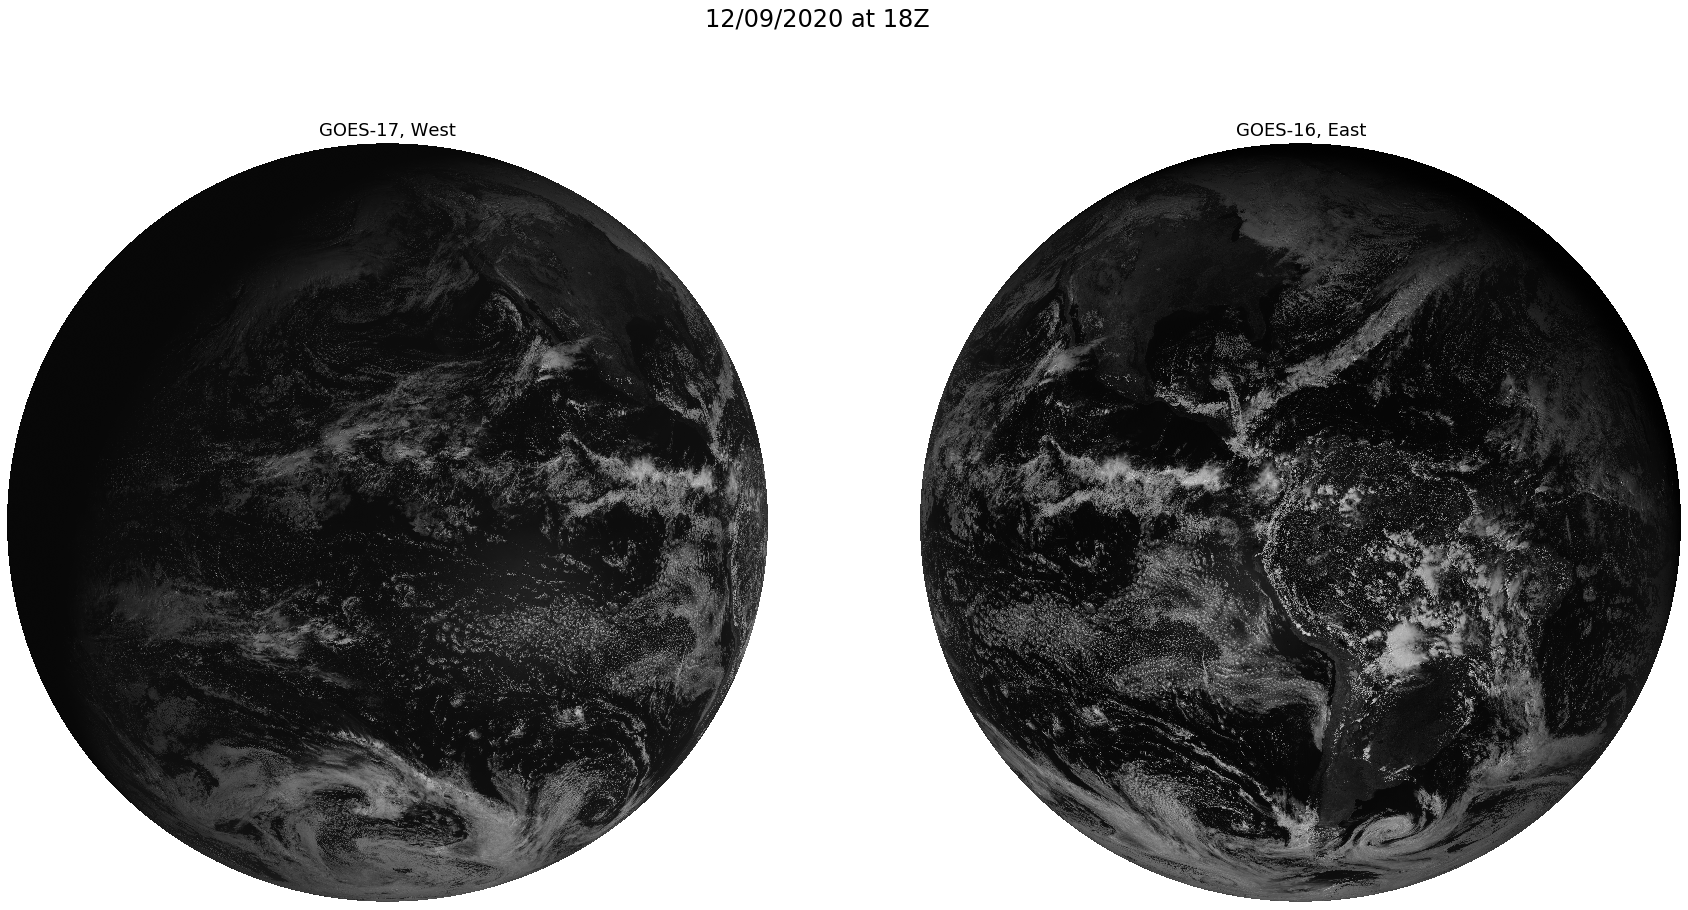

In [7]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(30,15));

# Fill plot data
ax1.imshow(dsWest.Rad, cmap='gray');
ax2.imshow(dsEast.Rad, cmap='gray');

# Add titles
fig.suptitle(date.strftime("%m/%d/%Y")+" at "+str(hour)+"Z", fontsize=24);
ax1.set_title('GOES-17, West',fontsize=18);
ax2.set_title('GOES-16, East',fontsize=18);

# Turn off axes
ax1.axis('off');
ax2.axis('off');

# Save figure
figFile = "GOES_East-West_"+date.strftime("%m%d%Y"+str(hour)+"Z")
plt.savefig(f'./images/{figFile}.png', dpi=300, facecolor='w', edgecolor='w')